In [136]:
# Library imports.
from pyswmm import Simulation, Links, Output
from swmm.toolkit.shared_enum import LinkAttribute, NodeAttribute, SubcatchAttribute
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Local imports.
from urbansurge.file_utils import set_inp_section, get_inp_section, add_prcp_timeseries, set_raingage

In [137]:
# Path to the SWMM inp file.
swmm_dir = Path(r"C:\Users\ay434\Box\Research\Digital_Twin_Interpretable_AI\SWMM\SWMM_Files\SWMM")
inp_name = "Canandaigua_Orig - Copy.inp"
out_name = "Canandaigua_Orig - Copy.out"

swmm_path = str(swmm_dir / inp_name)
swmm_out_path = str(swmm_dir / out_name)

In [138]:
def unpack_series(series):
    "Unpacks SWMM output series into datetime and values."
    dts = [key for key in series.keys()]
    values = [val for val in series.values()]
    
    return dts, values

## Databases and Experiments

In [164]:
# Precipitation database.
prcp_data_dict = {'experiment': [], 'prcp': []}

# Node and link (component) database.
comp_data_dict = {'experiment': [], 'datetime': []}

# Nodes.
nodes = [15, 16, 17, 18, 19, 20]
node_categories = ['depth']
for node in nodes:
    for cat in node_categories:
        comp_data_dict[f'n{node}_{cat}'] = []

# Links.
links = [1, 2, 3, 4, 5]
link_categories = ['flow']
for link in links:
    for cat in link_categories:
        comp_data_dict[f'c{link}_{cat}'] = []
        
# Subcatchment database.
subcatch_data_dict = {'experiment': [], 'datetime': []}
subcatchments = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
subcatch_categories = ['runoff', 'prcp']
for subcatchment in subcatchments:
    for cat in subcatch_categories:
        subcatch_data_dict[f's{subcatchment}_{cat}'] = []
        
# Perturbation database.
pert_data_dict = {'experiment': []}
pert_cats = ['roughness', 'diameter']
for link in links:
    for pert_cat in pert_cats:
        pert_data_dict[f'c{link}_{pert_cat}'] = []
        
print('>> Precipitation data dictionary')
print(prcp_data_dict, '\n')
print('>> Component data dictionary')
print(comp_data_dict, '\n')
print('>> Subcatchment data dictionary')
print(subcatch_data_dict, '\n')
print('>> Perturbation data dictionary')
print(pert_data_dict, '\n')

# Variables to alter and how they should be altered.
# =======================================================================================================

# Precipitation.
prcp_max = 0.5 # Maximum inches per time step.
prcp_min = 0 # Minimum inches per time step.

# Links.
min_roughness = 0.01
max_roughness = 0.03

# Link diameter ranges.
link_diams = {
    1: (1.9, 2.1),
    2: (3.4, 3.6),
    3: (3.4, 3.6),
    4: (1.9, 2.1),
    5: (1.9, 2.1)
}
# =======================================================================================================

# Experiments.
# =======================================================================================================
nexp = 100
for i in range(nexp):
    print('>>> Starting simulation {}'.format(i))
    
    # SWMM simulation.
    with Simulation(swmm_path) as sim:
        
        # Edit precipitation timeseries.
        # -----------------------------------    
        # Edit 1.
        ts_name = 'TS_Exp'
        ts_description = 'Experimental Timeseries'
        times = [0, 1, 2, 3, 4, 5, 6]
        values = np.random.uniform(prcp_min, prcp_max, len(times))
#         values = [0, 0.1, 0.3, 0.2, 0.2, 0.1, 0.1]
        add_prcp_timeseries(swmm_path, ts_name, ts_description, times, values, overwrite=True)

        # Set new timeseries to rain gauge.
        section = 'RAINGAGES'
        rg_ts_name = f'TIMESERIES {ts_name}'
        component_name = 1
        column_name = 'Source'
        set_raingage(swmm_path, column_name, component_name, rg_ts_name)
        
        # Add precipitation to precipitation data frame.
        prcp_data_dict['prcp'].extend(values)
        
        # Add experiment to precipitation data frame.
        prcp_exp_id = [i for _ in range(len(times))]
        prcp_data_dict['experiment'].extend(prcp_exp_id)
        # -----------------------------------

        # Edit link parameters.
        # -----------------------------------
        # Number of conduits/links to edit.
        n_links = np.random.randint(1, len(links)+1)

        # Choose the links to edit.
        links_to_edit = np.random.choice(links, size=n_links, replace=False)
#         links_to_edit = [3]

        # Edit link.
        for link_id in links_to_edit:
            # Component name to edit. 
            component_name = link_id
            
            # Roughness editing.
            # ----------------------------------------
            rough_section = 'CONDUITS'
            column_name = 'Roughness'

            # Random roughness value.
            rough_val = np.random.uniform(min_roughness, max_roughness)
            rough_val = 0.02

            # Set value.
            set_inp_section(swmm_path, rough_section, column_name, component_name, rough_val)
            # ----------------------------------------
            
            # Diameter editing.
            # ----------------------------------------
            diam_section = 'XSECTIONS'
            column_name = 'Geom1'

            # Decrease by a random percentage.
            new_diam = np.random.uniform(link_diams[link_id][0], link_diams[link_id][1])

            # Set the new diameter.
            set_inp_section(swmm_path, diam_section, column_name, component_name, new_diam)
            # ----------------------------------------
        # -----------------------------------
        
        # Link perturbed values. # TODO: Check if it's getting the correct pipe diameter.
        # -----------------------------------
        # Add the experiment number.
        pert_data_dict['experiment'].append(i)
        
        # Loop through links and get the diameter and roughness for each.
        for link in links:
            # Get current roughness.
            rough_section = 'CONDUITS'
            column_name = 'Roughness'
            component_name = link
            roughness = get_inp_section(swmm_path, rough_section, column_name, component_name)
            
            pert_data_dict[f'c{link}_roughness'].append(float(roughness))
            
            # Get current diameter.
            diam_section = 'XSECTIONS'
            column_name = 'Geom1'
            component_name = link
            diam = get_inp_section(swmm_path, diam_section, column_name, component_name)
            
            pert_data_dict[f'c{link}_diameter'].append(float(diam))
        # -----------------------------------
        
        # Run the model.
        # -----------------------------------
        for ind, step in enumerate(sim):
            if ind % 100 == 0:
                print(sim.current_time, ",", round(sim.percent_complete * 100))
        # -----------------------------------
        
    # Collect output.
    # -----------------------------------
    with Output(swmm_out_path) as out:
        # Unpack nodes.
        for node in nodes:
            for node_cat in node_categories:
                if node_cat == 'depth':
                    node_dt, node_series = unpack_series(out.node_series(str(node), NodeAttribute.INVERT_DEPTH))
                    comp_data_dict[f'n{node}_{node_cat}'].extend(node_series)
                    
        # Unpack links.
        for link in links:
            for link_cat in link_categories:
                if link_cat == 'flow':
                    link_dt, link_series = unpack_series(out.link_series(str(link), LinkAttribute.FLOW_RATE))
                    comp_data_dict[f'c{link}_{link_cat}'].extend(link_series)
                    
        # Unpack subcatchments.
        for subcatchment in subcatchments:
            for sub_cat in subcatch_categories:
                if sub_cat == 'runoff':
                    subcatch_dt, subcatch_series = unpack_series(out.subcatch_series(str(subcatchment), SubcatchAttribute.RUNOFF_RATE))
                    subcatch_data_dict[f's{subcatchment}_{sub_cat}'].extend(subcatch_series)
                elif sub_cat == 'prcp':
                    subcatch_dt, subcatch_series = unpack_series(out.subcatch_series(str(subcatchment), SubcatchAttribute.RAINFALL))
                    subcatch_data_dict[f's{subcatchment}_{sub_cat}'].extend(subcatch_series)
                    
        # Input time series.
        comp_data_dict['datetime'].extend(out.times)
        subcatch_data_dict['datetime'].extend(out.times)
        
        # Input experiment.
        experiment_id = [i for _ in range(len(out.times))]
        comp_data_dict['experiment'].extend(experiment_id)
        subcatch_data_dict['experiment'].extend(experiment_id)
    # -----------------------------------
    print('>>> Finished simulation {}'.format(i), '\n')
# =======================================================================================================

# Make data frames from the data dictionaries.
prcp_df = pd.DataFrame(prcp_data_dict)
comp_df = pd.DataFrame(comp_data_dict)
subcatch_df = pd.DataFrame(subcatch_data_dict)
pert_df = pd.DataFrame(pert_data_dict)

>> Precipitation data dictionary
{'experiment': [], 'prcp': []} 

>> Component data dictionary
{'experiment': [], 'datetime': [], 'n15_depth': [], 'n16_depth': [], 'n17_depth': [], 'n18_depth': [], 'n19_depth': [], 'n20_depth': [], 'c1_flow': [], 'c2_flow': [], 'c3_flow': [], 'c4_flow': [], 'c5_flow': []} 

>> Subcatchment data dictionary
{'experiment': [], 'datetime': [], 's1_runoff': [], 's1_prcp': [], 's2_runoff': [], 's2_prcp': [], 's3_runoff': [], 's3_prcp': [], 's4_runoff': [], 's4_prcp': [], 's5_runoff': [], 's5_prcp': [], 's6_runoff': [], 's6_prcp': [], 's7_runoff': [], 's7_prcp': [], 's8_runoff': [], 's8_prcp': [], 's9_runoff': [], 's9_prcp': [], 's10_runoff': [], 's10_prcp': [], 's11_runoff': [], 's11_prcp': []} 

>> Perturbation data dictionary
{'experiment': [], 'c1_roughness': [], 'c1_diameter': [], 'c2_roughness': [], 'c2_diameter': [], 'c3_roughness': [], 'c3_diameter': [], 'c4_roughness': [], 'c4_diameter': [], 'c5_roughness': [], 'c5_diameter': []} 

>>> Starting simul

2017-01-01 17:30:30 , 73
2017-01-01 18:20:30 , 76
2017-01-01 19:10:30 , 80
2017-01-01 20:00:30 , 83
2017-01-01 20:50:30 , 87
2017-01-01 21:40:30 , 90
2017-01-01 22:30:30 , 94
2017-01-01 23:20:30 , 97
>>> Finished simulation 4 

>>> Starting simulation 5
Updated Roughness value to 0.02 for 4 in 4
Updated Geom1 value to 2.0197443302853206 for 4 in 4
Updated Roughness value to 0.02 for 1 in 1
Updated Geom1 value to 2.053246889409194 for 1 in 1
Updated Roughness value to 0.02 for 5 in 5
Updated Geom1 value to 2.0986190293541385 for 5 in 5
Updated Roughness value to 0.02 for 2 in 2
Updated Geom1 value to 3.5210888765684456 for 2 in 2
Found Roughness value to be 0.02 for 1 in 1
Found Geom1 value to be 2.053246889409194 for 1 in 1
Found Roughness value to be 0.02 for 2 in 2
Found Geom1 value to be 3.5210888765684456 for 2 in 2
Found Roughness value to be 0.02 for 3 in 3
Found Geom1 value to be 3.528503934073443 for 3 in 3
Found Roughness value to be 0.02 for 4 in 4
Found Geom1 value to be 2.0

>>> Finished simulation 9 

>>> Starting simulation 10
Updated Roughness value to 0.02 for 1 in 1
Updated Geom1 value to 1.991106249786109 for 1 in 1
Updated Roughness value to 0.02 for 4 in 4
Updated Geom1 value to 1.9147311214301443 for 4 in 4
Found Roughness value to be 0.02 for 1 in 1
Found Geom1 value to be 1.991106249786109 for 1 in 1
Found Roughness value to be 0.02 for 2 in 2
Found Geom1 value to be 3.5523996585605544 for 2 in 2
Found Roughness value to be 0.02 for 3 in 3
Found Geom1 value to be 3.420029201889827 for 3 in 3
Found Roughness value to be 0.02 for 4 in 4
Found Geom1 value to be 1.9147311214301443 for 4 in 4
Found Roughness value to be 0.02 for 5 in 5
Found Geom1 value to be 2.0216686737546317 for 5 in 5
2017-01-01 00:00:30 , 0
2017-01-01 00:50:30 , 4
2017-01-01 01:40:30 , 7
2017-01-01 02:30:30 , 10
2017-01-01 03:20:30 , 14
2017-01-01 04:10:30 , 17
2017-01-01 05:00:30 , 21
2017-01-01 05:50:30 , 24
2017-01-01 06:40:30 , 28
2017-01-01 07:30:30 , 31
2017-01-01 08:20:30

Updated Roughness value to 0.02 for 5 in 5
Updated Geom1 value to 1.9736509177393011 for 5 in 5
Updated Roughness value to 0.02 for 1 in 1
Updated Geom1 value to 2.025291674565201 for 1 in 1
Updated Roughness value to 0.02 for 3 in 3
Updated Geom1 value to 3.4736504589127084 for 3 in 3
Updated Roughness value to 0.02 for 4 in 4
Updated Geom1 value to 1.9399941004556802 for 4 in 4
Updated Roughness value to 0.02 for 2 in 2
Updated Geom1 value to 3.4748537811705353 for 2 in 2
Found Roughness value to be 0.02 for 1 in 1
Found Geom1 value to be 2.025291674565201 for 1 in 1
Found Roughness value to be 0.02 for 2 in 2
Found Geom1 value to be 3.4748537811705353 for 2 in 2
Found Roughness value to be 0.02 for 3 in 3
Found Geom1 value to be 3.4736504589127084 for 3 in 3
Found Roughness value to be 0.02 for 4 in 4
Found Geom1 value to be 1.9399941004556802 for 4 in 4
Found Roughness value to be 0.02 for 5 in 5
Found Geom1 value to be 1.9736509177393011 for 5 in 5
2017-01-01 00:00:30 , 0
2017-01-

Updated Geom1 value to 1.9673615859865787 for 1 in 1
Updated Roughness value to 0.02 for 3 in 3
Updated Geom1 value to 3.517382834690386 for 3 in 3
Found Roughness value to be 0.02 for 1 in 1
Found Geom1 value to be 1.9673615859865787 for 1 in 1
Found Roughness value to be 0.02 for 2 in 2
Found Geom1 value to be 3.4031944013416147 for 2 in 2
Found Roughness value to be 0.02 for 3 in 3
Found Geom1 value to be 3.517382834690386 for 3 in 3
Found Roughness value to be 0.02 for 4 in 4
Found Geom1 value to be 1.900553961525316 for 4 in 4
Found Roughness value to be 0.02 for 5 in 5
Found Geom1 value to be 1.978936174268807 for 5 in 5
2017-01-01 00:00:30 , 0
2017-01-01 00:50:30 , 4
2017-01-01 01:40:30 , 7
2017-01-01 02:30:30 , 10
2017-01-01 03:20:30 , 14
2017-01-01 04:10:30 , 17
2017-01-01 05:00:30 , 21
2017-01-01 05:50:30 , 24
2017-01-01 06:40:30 , 28
2017-01-01 07:30:30 , 31
2017-01-01 08:20:30 , 35
2017-01-01 09:10:30 , 38
2017-01-01 10:00:30 , 42
2017-01-01 10:50:30 , 45
2017-01-01 11:40:3

Updated Roughness value to 0.02 for 5 in 5
Updated Geom1 value to 1.9784183346146291 for 5 in 5
Updated Roughness value to 0.02 for 1 in 1
Updated Geom1 value to 1.9059908997008244 for 1 in 1
Found Roughness value to be 0.02 for 1 in 1
Found Geom1 value to be 1.9059908997008244 for 1 in 1
Found Roughness value to be 0.02 for 2 in 2
Found Geom1 value to be 3.5703550897368865 for 2 in 2
Found Roughness value to be 0.02 for 3 in 3
Found Geom1 value to be 3.438618280455033 for 3 in 3
Found Roughness value to be 0.02 for 4 in 4
Found Geom1 value to be 2.0886603694168078 for 4 in 4
Found Roughness value to be 0.02 for 5 in 5
Found Geom1 value to be 1.9784183346146291 for 5 in 5
2017-01-01 00:00:30 , 0
2017-01-01 00:50:30 , 4
2017-01-01 01:40:30 , 7
2017-01-01 02:30:30 , 10
2017-01-01 03:20:30 , 14
2017-01-01 04:10:30 , 17
2017-01-01 05:00:30 , 21
2017-01-01 05:50:30 , 24
2017-01-01 06:40:30 , 28
2017-01-01 07:30:30 , 31
2017-01-01 08:20:30 , 35
2017-01-01 09:10:30 , 38
2017-01-01 10:00:30 , 

>>> Finished simulation 32 

>>> Starting simulation 33
Updated Roughness value to 0.02 for 3 in 3
Updated Geom1 value to 3.4213092993126533 for 3 in 3
Updated Roughness value to 0.02 for 2 in 2
Updated Geom1 value to 3.4297270458218976 for 2 in 2
Updated Roughness value to 0.02 for 1 in 1
Updated Geom1 value to 2.0598553820634433 for 1 in 1
Found Roughness value to be 0.02 for 1 in 1
Found Geom1 value to be 2.0598553820634433 for 1 in 1
Found Roughness value to be 0.02 for 2 in 2
Found Geom1 value to be 3.4297270458218976 for 2 in 2
Found Roughness value to be 0.02 for 3 in 3
Found Geom1 value to be 3.4213092993126533 for 3 in 3
Found Roughness value to be 0.02 for 4 in 4
Found Geom1 value to be 1.9400739136023557 for 4 in 4
Found Roughness value to be 0.02 for 5 in 5
Found Geom1 value to be 2.069350310248208 for 5 in 5
2017-01-01 00:00:30 , 0
2017-01-01 00:50:30 , 4
2017-01-01 01:40:30 , 7
2017-01-01 02:30:30 , 10
2017-01-01 03:20:30 , 14
2017-01-01 04:10:30 , 17
2017-01-01 05:00:30 

>>> Finished simulation 38 

>>> Starting simulation 39
Updated Roughness value to 0.02 for 5 in 5
Updated Geom1 value to 1.9316527105691412 for 5 in 5
Updated Roughness value to 0.02 for 4 in 4
Updated Geom1 value to 1.912060026366757 for 4 in 4
Updated Roughness value to 0.02 for 3 in 3
Updated Geom1 value to 3.4556010218353324 for 3 in 3
Updated Roughness value to 0.02 for 2 in 2
Updated Geom1 value to 3.5697730401750523 for 2 in 2
Updated Roughness value to 0.02 for 1 in 1
Updated Geom1 value to 1.9114106638860817 for 1 in 1
Found Roughness value to be 0.02 for 1 in 1
Found Geom1 value to be 1.9114106638860817 for 1 in 1
Found Roughness value to be 0.02 for 2 in 2
Found Geom1 value to be 3.5697730401750523 for 2 in 2
Found Roughness value to be 0.02 for 3 in 3
Found Geom1 value to be 3.4556010218353324 for 3 in 3
Found Roughness value to be 0.02 for 4 in 4
Found Geom1 value to be 1.912060026366757 for 4 in 4
Found Roughness value to be 0.02 for 5 in 5
Found Geom1 value to be 1.9316

2017-01-01 04:10:30 , 17
2017-01-01 05:00:30 , 21
2017-01-01 05:50:30 , 24
2017-01-01 06:40:30 , 28
2017-01-01 07:30:30 , 31
2017-01-01 08:20:30 , 35
2017-01-01 09:10:30 , 38
2017-01-01 10:00:30 , 42
2017-01-01 10:50:30 , 45
2017-01-01 11:40:30 , 49
2017-01-01 12:30:30 , 52
2017-01-01 13:20:30 , 56
2017-01-01 14:10:30 , 59
2017-01-01 15:00:30 , 63
2017-01-01 15:50:30 , 66
2017-01-01 16:40:30 , 69
2017-01-01 17:30:30 , 73
2017-01-01 18:20:30 , 76
2017-01-01 19:10:30 , 80
2017-01-01 20:00:30 , 83
2017-01-01 20:50:30 , 87
2017-01-01 21:40:30 , 90
2017-01-01 22:30:30 , 94
2017-01-01 23:20:30 , 97
>>> Finished simulation 44 

>>> Starting simulation 45
Updated Roughness value to 0.02 for 2 in 2
Updated Geom1 value to 3.4927807264670965 for 2 in 2
Updated Roughness value to 0.02 for 1 in 1
Updated Geom1 value to 2.0867422813478393 for 1 in 1
Updated Roughness value to 0.02 for 5 in 5
Updated Geom1 value to 1.9417575027022158 for 5 in 5
Updated Roughness value to 0.02 for 3 in 3
Updated Geom1

>>> Finished simulation 49 

>>> Starting simulation 50
Updated Roughness value to 0.02 for 5 in 5
Updated Geom1 value to 2.0480846293192294 for 5 in 5
Updated Roughness value to 0.02 for 3 in 3
Updated Geom1 value to 3.5141451894667473 for 3 in 3
Updated Roughness value to 0.02 for 1 in 1
Updated Geom1 value to 2.033562296490247 for 1 in 1
Updated Roughness value to 0.02 for 2 in 2
Updated Geom1 value to 3.4891364892977887 for 2 in 2
Updated Roughness value to 0.02 for 4 in 4
Updated Geom1 value to 1.9196220225781024 for 4 in 4
Found Roughness value to be 0.02 for 1 in 1
Found Geom1 value to be 2.033562296490247 for 1 in 1
Found Roughness value to be 0.02 for 2 in 2
Found Geom1 value to be 3.4891364892977887 for 2 in 2
Found Roughness value to be 0.02 for 3 in 3
Found Geom1 value to be 3.5141451894667473 for 3 in 3
Found Roughness value to be 0.02 for 4 in 4
Found Geom1 value to be 1.9196220225781024 for 4 in 4
Found Roughness value to be 0.02 for 5 in 5
Found Geom1 value to be 2.0480

Updated Roughness value to 0.02 for 2 in 2
Updated Geom1 value to 3.582237914177704 for 2 in 2
Updated Roughness value to 0.02 for 4 in 4
Updated Geom1 value to 2.099869405791613 for 4 in 4
Updated Roughness value to 0.02 for 3 in 3
Updated Geom1 value to 3.412585372007295 for 3 in 3
Updated Roughness value to 0.02 for 5 in 5
Updated Geom1 value to 1.9292222584958412 for 5 in 5
Found Roughness value to be 0.02 for 1 in 1
Found Geom1 value to be 1.9917329840354638 for 1 in 1
Found Roughness value to be 0.02 for 2 in 2
Found Geom1 value to be 3.582237914177704 for 2 in 2
Found Roughness value to be 0.02 for 3 in 3
Found Geom1 value to be 3.412585372007295 for 3 in 3
Found Roughness value to be 0.02 for 4 in 4
Found Geom1 value to be 2.099869405791613 for 4 in 4
Found Roughness value to be 0.02 for 5 in 5
Found Geom1 value to be 1.9292222584958412 for 5 in 5
2017-01-01 00:00:30 , 0
2017-01-01 00:50:30 , 4
2017-01-01 01:40:30 , 7
2017-01-01 02:30:30 , 10
2017-01-01 03:20:30 , 14
2017-01-01

2017-01-01 18:20:30 , 76
2017-01-01 19:10:30 , 80
2017-01-01 20:00:30 , 83
2017-01-01 20:50:30 , 87
2017-01-01 21:40:30 , 90
2017-01-01 22:30:30 , 94
2017-01-01 23:20:30 , 97
>>> Finished simulation 60 

>>> Starting simulation 61
Updated Roughness value to 0.02 for 5 in 5
Updated Geom1 value to 1.9579129706388625 for 5 in 5
Found Roughness value to be 0.02 for 1 in 1
Found Geom1 value to be 2.0010753745053322 for 1 in 1
Found Roughness value to be 0.02 for 2 in 2
Found Geom1 value to be 3.455618094496805 for 2 in 2
Found Roughness value to be 0.02 for 3 in 3
Found Geom1 value to be 3.547318938681924 for 3 in 3
Found Roughness value to be 0.02 for 4 in 4
Found Geom1 value to be 2.015038105154872 for 4 in 4
Found Roughness value to be 0.02 for 5 in 5
Found Geom1 value to be 1.9579129706388625 for 5 in 5
2017-01-01 00:00:30 , 0
2017-01-01 00:50:30 , 4
2017-01-01 01:40:30 , 7
2017-01-01 02:30:30 , 10
2017-01-01 03:20:30 , 14
2017-01-01 04:10:30 , 17
2017-01-01 05:00:30 , 21
2017-01-01 05:

Found Geom1 value to be 2.0245741191490283 for 4 in 4
Found Roughness value to be 0.02 for 5 in 5
Found Geom1 value to be 2.0671027472289545 for 5 in 5
2017-01-01 00:00:30 , 0
2017-01-01 00:50:30 , 4
2017-01-01 01:40:30 , 7
2017-01-01 02:30:30 , 10
2017-01-01 03:20:30 , 14
2017-01-01 04:10:30 , 17
2017-01-01 05:00:30 , 21
2017-01-01 05:50:30 , 24
2017-01-01 06:40:30 , 28
2017-01-01 07:30:30 , 31
2017-01-01 08:20:30 , 35
2017-01-01 09:10:30 , 38
2017-01-01 10:00:30 , 42
2017-01-01 10:50:30 , 45
2017-01-01 11:40:30 , 49
2017-01-01 12:30:30 , 52
2017-01-01 13:20:30 , 56
2017-01-01 14:10:30 , 59
2017-01-01 15:00:30 , 63
2017-01-01 15:50:30 , 66
2017-01-01 16:40:30 , 69
2017-01-01 17:30:30 , 73
2017-01-01 18:20:30 , 76
2017-01-01 19:10:30 , 80
2017-01-01 20:00:30 , 83
2017-01-01 20:50:30 , 87
2017-01-01 21:40:30 , 90
2017-01-01 22:30:30 , 94
2017-01-01 23:20:30 , 97
>>> Finished simulation 66 

>>> Starting simulation 67
Updated Roughness value to 0.02 for 4 in 4
Updated Geom1 value to 1.97

2017-01-01 22:30:30 , 94
2017-01-01 23:20:30 , 97
>>> Finished simulation 71 

>>> Starting simulation 72
Updated Roughness value to 0.02 for 3 in 3
Updated Geom1 value to 3.421949531619701 for 3 in 3
Updated Roughness value to 0.02 for 2 in 2
Updated Geom1 value to 3.548315710126244 for 2 in 2
Found Roughness value to be 0.02 for 1 in 1
Found Geom1 value to be 2.076248068907925 for 1 in 1
Found Roughness value to be 0.02 for 2 in 2
Found Geom1 value to be 3.548315710126244 for 2 in 2
Found Roughness value to be 0.02 for 3 in 3
Found Geom1 value to be 3.421949531619701 for 3 in 3
Found Roughness value to be 0.02 for 4 in 4
Found Geom1 value to be 1.9939390355187427 for 4 in 4
Found Roughness value to be 0.02 for 5 in 5
Found Geom1 value to be 1.9608760891991812 for 5 in 5
2017-01-01 00:00:30 , 0
2017-01-01 00:50:30 , 4
2017-01-01 01:40:30 , 7
2017-01-01 02:30:30 , 10
2017-01-01 03:20:30 , 14
2017-01-01 04:10:30 , 17
2017-01-01 05:00:30 , 21
2017-01-01 05:50:30 , 24
2017-01-01 06:40:30 

>>> Finished simulation 77 

>>> Starting simulation 78
Updated Roughness value to 0.02 for 2 in 2
Updated Geom1 value to 3.5121317395195377 for 2 in 2
Updated Roughness value to 0.02 for 4 in 4
Updated Geom1 value to 1.900274347572238 for 4 in 4
Updated Roughness value to 0.02 for 3 in 3
Updated Geom1 value to 3.5797577347499177 for 3 in 3
Found Roughness value to be 0.02 for 1 in 1
Found Geom1 value to be 2.0405254353577575 for 1 in 1
Found Roughness value to be 0.02 for 2 in 2
Found Geom1 value to be 3.5121317395195377 for 2 in 2
Found Roughness value to be 0.02 for 3 in 3
Found Geom1 value to be 3.5797577347499177 for 3 in 3
Found Roughness value to be 0.02 for 4 in 4
Found Geom1 value to be 1.900274347572238 for 4 in 4
Found Roughness value to be 0.02 for 5 in 5
Found Geom1 value to be 2.0104087105500583 for 5 in 5
2017-01-01 00:00:30 , 0
2017-01-01 00:50:30 , 4
2017-01-01 01:40:30 , 7
2017-01-01 02:30:30 , 10
2017-01-01 03:20:30 , 14
2017-01-01 04:10:30 , 17
2017-01-01 05:00:30 ,

Updated Roughness value to 0.02 for 3 in 3
Updated Geom1 value to 3.542533812794556 for 3 in 3
Updated Roughness value to 0.02 for 4 in 4
Updated Geom1 value to 1.9786499022097623 for 4 in 4
Updated Roughness value to 0.02 for 1 in 1
Updated Geom1 value to 1.982781734335206 for 1 in 1
Found Roughness value to be 0.02 for 1 in 1
Found Geom1 value to be 1.982781734335206 for 1 in 1
Found Roughness value to be 0.02 for 2 in 2
Found Geom1 value to be 3.446069222126719 for 2 in 2
Found Roughness value to be 0.02 for 3 in 3
Found Geom1 value to be 3.542533812794556 for 3 in 3
Found Roughness value to be 0.02 for 4 in 4
Found Geom1 value to be 1.9786499022097623 for 4 in 4
Found Roughness value to be 0.02 for 5 in 5
Found Geom1 value to be 1.9506999020073146 for 5 in 5
2017-01-01 00:00:30 , 0
2017-01-01 00:50:30 , 4
2017-01-01 01:40:30 , 7
2017-01-01 02:30:30 , 10
2017-01-01 03:20:30 , 14
2017-01-01 04:10:30 , 17
2017-01-01 05:00:30 , 21
2017-01-01 05:50:30 , 24
2017-01-01 06:40:30 , 28
2017-

>>> Finished simulation 88 

>>> Starting simulation 89
Updated Roughness value to 0.02 for 4 in 4
Updated Geom1 value to 1.970874856717082 for 4 in 4
Updated Roughness value to 0.02 for 3 in 3
Updated Geom1 value to 3.531162923585754 for 3 in 3
Updated Roughness value to 0.02 for 2 in 2
Updated Geom1 value to 3.466885030552758 for 2 in 2
Found Roughness value to be 0.02 for 1 in 1
Found Geom1 value to be 2.081474232534307 for 1 in 1
Found Roughness value to be 0.02 for 2 in 2
Found Geom1 value to be 3.466885030552758 for 2 in 2
Found Roughness value to be 0.02 for 3 in 3
Found Geom1 value to be 3.531162923585754 for 3 in 3
Found Roughness value to be 0.02 for 4 in 4
Found Geom1 value to be 1.970874856717082 for 4 in 4
Found Roughness value to be 0.02 for 5 in 5
Found Geom1 value to be 2.0695006542425864 for 5 in 5
2017-01-01 00:00:30 , 0
2017-01-01 00:50:30 , 4
2017-01-01 01:40:30 , 7
2017-01-01 02:30:30 , 10
2017-01-01 03:20:30 , 14
2017-01-01 04:10:30 , 17
2017-01-01 05:00:30 , 21
2

Updated Roughness value to 0.02 for 3 in 3
Updated Geom1 value to 3.4804343134242455 for 3 in 3
Updated Roughness value to 0.02 for 5 in 5
Updated Geom1 value to 1.9400332285154454 for 5 in 5
Updated Roughness value to 0.02 for 1 in 1
Updated Geom1 value to 1.9598735827319476 for 1 in 1
Updated Roughness value to 0.02 for 4 in 4
Updated Geom1 value to 1.9235646160944286 for 4 in 4
Found Roughness value to be 0.02 for 1 in 1
Found Geom1 value to be 1.9598735827319476 for 1 in 1
Found Roughness value to be 0.02 for 2 in 2
Found Geom1 value to be 3.4825992984622394 for 2 in 2
Found Roughness value to be 0.02 for 3 in 3
Found Geom1 value to be 3.4804343134242455 for 3 in 3
Found Roughness value to be 0.02 for 4 in 4
Found Geom1 value to be 1.9235646160944286 for 4 in 4
Found Roughness value to be 0.02 for 5 in 5
Found Geom1 value to be 1.9400332285154454 for 5 in 5
2017-01-01 00:00:30 , 0
2017-01-01 00:50:30 , 4
2017-01-01 01:40:30 , 7
2017-01-01 02:30:30 , 10
2017-01-01 03:20:30 , 14
2017

In [159]:
pert_df.loc[pert_df.experiment==i,'c3_diameter'].to_numpy()[0]

3.4023615898160866

## Plotting

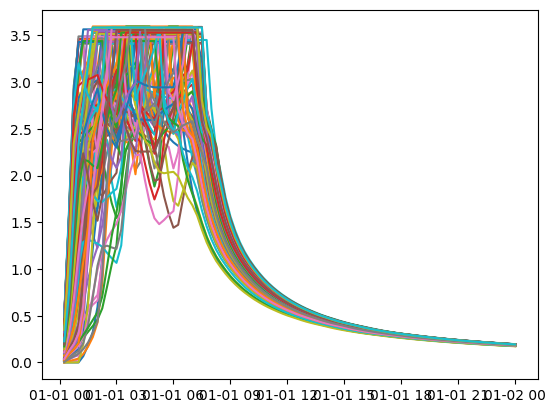

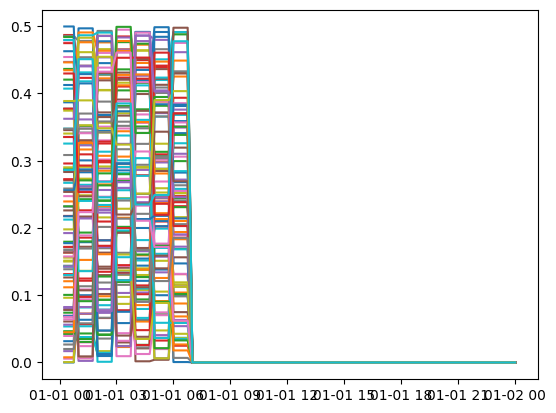

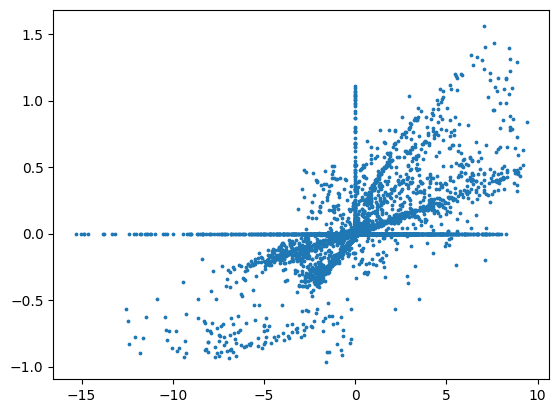

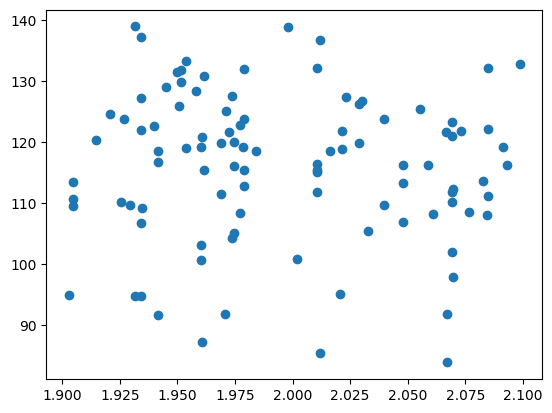

In [168]:
fig, ax = plt.subplots()
for i in range(nexp):
    ax.plot(comp_df.loc[comp_df.experiment==i,'datetime'], comp_df.loc[comp_df.experiment==i,'n17_depth'])

plt.show()

fig, ax = plt.subplots()
for i in range(nexp):
    ax.plot(subcatch_df.loc[subcatch_df.experiment==i,'datetime'], subcatch_df.loc[subcatch_df.experiment==i,'s8_prcp'])

plt.show()

# Outflow difference vs runoff difference.
outfall_diffs_total = []
runoff_diffs_total = []
for i in range(nexp):
    outfall_depths = comp_df.loc[comp_df.experiment==i,'n17_depth'].to_numpy()
    outfall_diffs = outfall_depths[1:] - outfall_depths[:-1]
    outfall_diffs_total.extend(list(outfall_diffs))
    
    runoffs = subcatch_df.loc[subcatch_df.experiment==i,'s5_runoff'].to_numpy()
    runoff_diffs = runoffs[1:] - runoffs[:-1]
    runoff_diffs_total.extend(list(runoff_diffs))

fig, ax = plt.subplots()
ax.scatter(runoff_diffs_total[:-1], outfall_diffs_total[1:], 3)

# Outfall sum vs. diameter.
outfall_sums = []
diameters = []
for i in range(nexp):
    outfall_depths = comp_df.loc[comp_df.experiment==i,'n17_depth'].to_numpy()
    outfall_sums.append(np.sum(outfall_depths))
    
    diameters.append(pert_df.loc[pert_df.experiment==i,'c5_diameter'].to_numpy()[0])
    
fig, ax = plt.subplots()
ax.scatter(diameters, outfall_sums)
